In [1]:
import pandas as pd
import numpy as np
import string
import re

In [2]:
import spacy
nlp1 = spacy.load('en_core_web_sm')
nlp2 = spacy.load('en_core_web_sm')

In [3]:
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

In [4]:
def pre_process(newString):
    newString = newString.replace("-"," ")
    newString = newString.replace("'s","")
    return newString.lower()

In [11]:
def rep_entity(s):
    doc = s
    newString = str(s)
    for e in reversed(doc.ents): #reversed to not modify the offsets of other entities when substituting
        label = e.label_
        if label in ["ORG","PERSON","EVENT","PRODUCT", "GPE", "LOC"]:
            continue

        start = e.start_char
        end = start + len(e.text)
        newString = newString[:start] + label + newString[end:]

    newString = newString.strip()
    newString = newString.translate(str.maketrans(dict.fromkeys(string.punctuation + "\n\t’:")))
    return newString

In [12]:
def post_process(s):
    doc = s
    tokens = [word.lemma_ for word in doc if not word.is_stop]
    text = " ".join(tokens)
    return text 

In [13]:
def test_sent(s):
    s = pre_process(s)
    s = nlp1(s)
    s = rep_entity(s)
    s = nlp2(s)
    s = post_process(s)
    return s

### Importing dataset

In [14]:
df = pd.read_csv('updated.csv',sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38013 entries, 0 to 38012
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   38013 non-null  object
 1   label   38013 non-null  object
dtypes: object(2)
memory usage: 594.1+ KB


In [15]:
df["title"] = df.title.apply(pre_process) 
df.sample(10)

,title,label
14655,fema: palm beach county new flood zone maps no...,NON DISASTER_
16239,what the latest ebola infection says about odd...,DISASTER_
10840,lyme disease researcher says he surprised by r...,NON DISASTER_
18102,shanghai issues fifth red heat alert,DISASTER_
25466,10 signs you attended an all girls catholic hi...,NON DISASTER_
24286,republicans say goodbye to latino voters,NON DISASTER_
1686,"despite rain, nearly half of new hampshire sti...",DISASTER_
31228,watch the republican national convention live,NON DISASTER_
29152,what the stylelist staff bought this weekend: ...,NON DISASTER_
19422,like an olympian: healthy eating tips from oly...,NON DISASTER_


In [16]:
df["title"] = list(nlp1.pipe(df.title.values))
df.head()

,title,label
0,"(pilot, ,, skydivers, survive, fiery, crash, i...",DISASTER_
1,"(officials, :, pilot, dead, in, small, plane, ...",DISASTER_
2,"(brother, identifies, rye, man, as, pilot, kil...",DISASTER_
3,"(brother, identifies, rye, man, as, pilot, kil...",DISASTER_
4,"(chapecoense, team, plane, crash, kills, most,...",DISASTER_


In [17]:
df["title"] = df.title.apply(rep_entity)
df.head()

,title,label
0,pilot skydivers survive fiery crash in phoenix...,DISASTER_
1,officials pilot dead in small plane crash in a...,DISASTER_
2,brother identifies rye man as pilot killed in ...,DISASTER_
3,brother identifies rye man as pilot killed in ...,DISASTER_
4,chapecoense team plane crash kills most soccer...,DISASTER_


In [18]:
df["title"] = list(nlp2.pipe(df.title.values))
df.head()

,title,label
0,"(pilot, skydivers, survive, fiery, crash, in, ...",DISASTER_
1,"(officials, pilot, dead, in, small, plane, cra...",DISASTER_
2,"(brother, identifies, rye, man, as, pilot, kil...",DISASTER_
3,"(brother, identifies, rye, man, as, pilot, kil...",DISASTER_
4,"(chapecoense, team, plane, crash, kills, most,...",DISASTER_


In [19]:
df["title"] = df.title.apply(post_process)
df.head(10)

,title,label
0,pilot skydiver survive fiery crash phoenix suburb,DISASTER_
1,official pilot dead small plane crash atlanta ...,DISASTER_
2,brother identify rye man pilot kill new york p...,DISASTER_
3,brother identify rye man pilot kill new york p...,DISASTER_
4,chapecoense team plane crash kill soccer playe...,DISASTER_
5,official cardinal kill plane crash north denver,DISASTER_
6,russia mourn plane crash dead,DISASTER_
7,CARDINAL injure small plane crash isle wight a...,DISASTER_
8,pilot error contribute deadly papua new guinea...,DISASTER_
9,airline warn fly sinai wake russian plane crash,DISASTER_


In [22]:
df = df.drop_duplicates()

In [23]:
df.to_csv("data_processed.csv",index=False)

In [2]:
df = pd.read_csv("data_processed.csv",engine='python')
df = df.dropna()
df.head(10)

,title,label
0,pilot skydiver survive fiery crash phoenix suburb,DISASTER_
1,official pilot dead small plane crash atlanta ...,DISASTER_
2,brother identify rye man pilot kill new york p...,DISASTER_
3,chapecoense team plane crash kill soccer playe...,DISASTER_
4,official cardinal kill plane crash north denver,DISASTER_
5,russia mourn plane crash dead,DISASTER_
6,CARDINAL injure small plane crash isle wight a...,DISASTER_
7,pilot error contribute deadly papua new guinea...,DISASTER_
8,airline warn fly sinai wake russian plane crash,DISASTER_
9,lech kaczynski wife maria exhume victim DATE p...,DISASTER_


In [106]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tv = TfidfVectorizer()
# X = tv.fit_transform(df.title).toarray()
# y = df.label.values

In [3]:
#BOW model
from sklearn.feature_extraction.text import CountVectorizer
# Creating sparse matrix of top 2500 tokens
cv = CountVectorizer(max_features = 250)
X = cv.fit_transform(df.title).toarray()
y = df.label.values

In [4]:
import pickle

with open("preprocessor.pkl","wb") as model:
    pickle.dump(cv,model)

In [26]:
X.shape

(37202, 250)

In [27]:
# Splitting the dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [26]:
## Training the Naive Bayes model on the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [28]:
from sklearn.svm import SVC
SVC_classifier = SVC(kernel = 'rbf')
SVC_classifier.fit(X_train, y_train)
y_pred_SVC = SVC_classifier.predict(X_test)

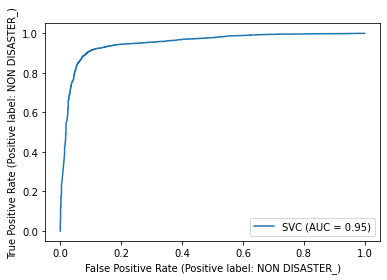

In [29]:
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt  
a = plot_roc_curve(SVC_classifier, X_test, y_test, name = 'SVC')
#b = plot_roc_curve(classifier, X_test, y_test, name = 'GaussianNB',ax=a.ax_)
plt.show()

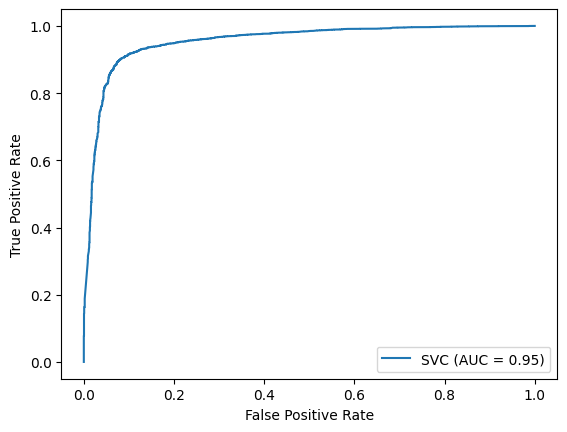

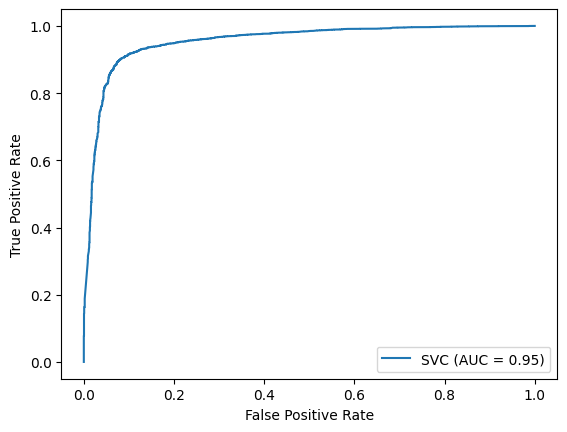

In [30]:
plot_roc_curve(SVC_classifier, X_test, y_test, name = 'SVC')
plt.show()

In [31]:
import pickle

with open("binary_classifier.pkl","wb") as model:
    pickle.dump(SVC_classifier,model)


In [111]:
from joblib import dump, load
dump(cv, 'cv.joblib')
dump(classifier, 'classifier.joblib') 

['classifier.joblib']

In [112]:
## Testing the model on test set
y_pred = classifier.predict(X_test)
y_pred

array(['NON DISASTER_', 'DISASTER_', 'DISASTER_', ..., 'DISASTER_',
       'DISASTER_', 'DISASTER_'], dtype='<U13')

In [124]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('  Confusion matrix : \n', cm)
print("The model accuracy is", accuracy )

  Confusion matrix : 
 [[2330  172]
 [2064 3035]]
The model accuracy is 0.7058281805025655


In [2]:
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.reset()

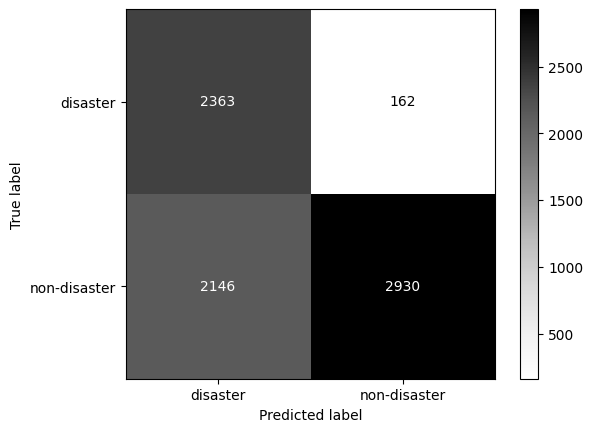

In [33]:
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot
disp = plot_confusion_matrix(classifier, X_test, y_test,
                             cmap=plt.cm.Greys,
                             display_labels=['disaster','non-disaster'],
                                 normalize=None)
plt.show()

In [37]:
y_pred_SVC_train = SVC_classifier.predict(X_train)

In [42]:
from sklearn.metrics import precision_score, recall_score,accuracy_score
print("precision test",precision_score(y_test,y_pred_SVC,pos_label='DISASTER_'))
print("recall test",recall_score(y_test,y_pred_SVC,pos_label='DISASTER_'))
print("accuracy test",accuracy_score(y_test,y_pred_SVC))
print("precision train",precision_score(y_train,y_pred_SVC_train,pos_label='DISASTER_'))
print("recall train",recall_score(y_train,y_pred_SVC_train,pos_label='DISASTER_'))
print("accuracy train",accuracy_score(y_train,y_pred_SVC_train))

precision test 0.8611002731174405
recall test 0.8740594059405941
accuracy test 0.911327456913564
precision train 0.8968923844235565
recall train 0.9216439976345357
accuracy train 0.9384888654978455


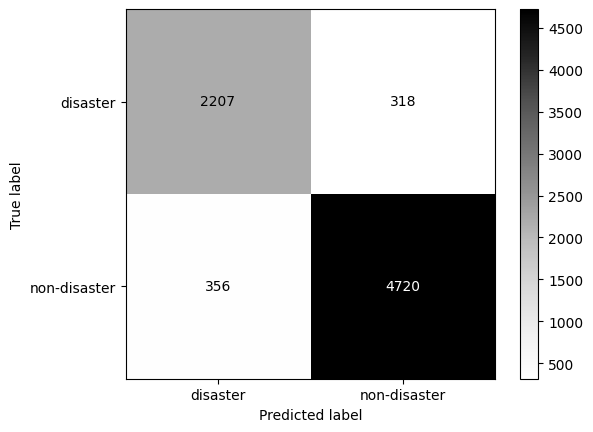

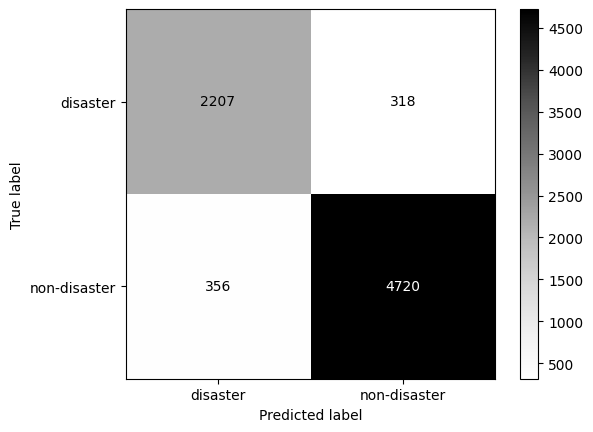

In [32]:
disp = plot_confusion_matrix(SVC_classifier, X_test, y_test,
                             cmap=plt.cm.Greys,
                             display_labels=['disaster','non-disaster'],
                                 normalize=None)
plt.show()

In [125]:
accuracy = accuracy_score(y_test, y_pred_SVC)
cm = confusion_matrix(y_test, y_pred_SVC)
print('  Confusion matrix : \n', cm)
print("The model accuracy is", accuracy )

  Confusion matrix : 
 [[2167  335]
 [ 400 4699]]
The model accuracy is 0.9033021970793317


In [114]:
def predict(test_reviews):
    if isinstance(test_reviews,str):
        test_review = test_reviews
        test_review = test_sent(test_review)
        test_input_array = cv.transform([test_review]).toarray()
        test_input_array = np.transpose(test_input_array)
        test_input_array = test_input_array[:,0]
        res = classifier.predict([test_input_array])
        return res[0]
    elif isinstance(test_reviews,list):
        result=[]
        for test_review in test_reviews:
            test_review = test_sent(test_review)
            test_input_array = cv.transform([test_review]).toarray()
            test_input_array = np.transpose(test_input_array)
            test_input_array = test_input_array[:,0]
            res = classifier.predict([test_input_array])
            result.append(res[0])
        return result
    print('Please provide a string or a list.')

In [115]:
test = ["5 man died at airplane crash yestarday","4 people went to justin bieber concert"]
predict(test)

['DISASTER_', 'NON DISASTER_']

In [116]:
test = "a man did nothing"
predict(test)

'DISASTER_'

In [117]:
df = pd.read_csv('all-news.csv').sample(100)
df.head(10)

,title,label
54210,Nun in iconic Italian earthquake photo sent ad...,DISASTER_
414726,"Yosemite Virus: 10,000 At Risk Of Hantavirus F...",NON DISASTER_
385916,"Kanye West, APC Collaboration Is Officially Ha...",NON DISASTER_
120698,Senator McConnell speaks on flooding in Kentucky,DISASTER_
273257,Oscar-Nominated Iranian Director Asghar Farhad...,NON DISASTER_
39759,Victims Buried As Search For Albania Quake Sur...,DISASTER_
10204,Two hospitalised after light plane crashes one...,DISASTER_
399774,"Last Man On The Moon, Eugene Cernan, Calls Spa...",NON DISASTER_
188894,"AccuWeather: Warm And Humid, T'Storm",DISASTER_
381397,2013 VMAs Bring MTV's Party To Brooklyn (LIVE ...,NON DISASTER_


In [118]:
df["predicted"] = predict(list(df["title"]))

In [119]:
df[df["label"] == df["predicted"]]

,title,label,predicted
54210,Nun in iconic Italian earthquake photo sent ad...,DISASTER_,DISASTER_
385916,"Kanye West, APC Collaboration Is Officially Ha...",NON DISASTER_,NON DISASTER_
120698,Senator McConnell speaks on flooding in Kentucky,DISASTER_,DISASTER_
39759,Victims Buried As Search For Albania Quake Sur...,DISASTER_,DISASTER_
10204,Two hospitalised after light plane crashes one...,DISASTER_,DISASTER_
...,...,...,...
83942,One dead after explosion at Aliso Viejo office...,DISASTER_,DISASTER_
36503,"Magnitude 6.8 quake strikes southern Sumatra, ...",DISASTER_,DISASTER_
174059,Burnout car dumped in Dudley Park,DISASTER_,DISASTER_
219028,Lightning punches 3x3 foot hole in runway at P...,DISASTER_,DISASTER_


In [120]:
df[df["label"] != df["predicted"]]

,title,label,predicted
414726,"Yosemite Virus: 10,000 At Risk Of Hantavirus F...",NON DISASTER_,DISASTER_
273257,Oscar-Nominated Iranian Director Asghar Farhad...,NON DISASTER_,DISASTER_
399774,"Last Man On The Moon, Eugene Cernan, Calls Spa...",NON DISASTER_,DISASTER_
151964,Mom Dies In Road Rage Incident While Giving He...,DISASTER_,NON DISASTER_
314334,The Ad Industry Is Finally Promising To Make O...,NON DISASTER_,DISASTER_
360280,Brighten Your Brunch Without the Fuss: Sunburs...,NON DISASTER_,DISASTER_
197836,Florida Candidates Change Plans Due To Michael,DISASTER_,NON DISASTER_
378683,Victoria's Secret Fashion Show Casting Is 'Qui...,NON DISASTER_,DISASTER_
114889,"Box Office: 'Catching Fire,' 'Frozen' Making T...",DISASTER_,NON DISASTER_
264425,13 MLB Players Denounce Repression And Deaths ...,NON DISASTER_,DISASTER_


In [167]:
new_df = pd.read_csv('../../Desktop/dataset_labelled.csv')[["text","category"]]

In [168]:
new_df.category.value_counts()

non-disaster             5162
disaster-irrelevant      1425
not sure                 1336
storm                    1278
earthquake               1233
road_accident            1214
fire_and_explosion       1207
air_accident             1195
flood                    1059
wildfire                 1032
landslide                1026
epidemic                  875
avalanche                 655
rainfall                  647
drought                   618
extreme_temperature       326
thunder_and_lightning     306
Name: category, dtype: int64

In [169]:
def func(s):
    if s in ['non-disaster','disaster-irrelevant']:
        return 'NON DISASTER_'
    elif s in ['not sure']:
        return 'NONE'
    else:
        return 'DISASTER_'

In [170]:
new_df['label'] = new_df.category.apply(func)

In [171]:
new_df.label.value_counts()

DISASTER_        12671
NON DISASTER_     6587
NONE              1336
Name: label, dtype: int64

In [172]:
new_df= new_df[new_df.label != 'NONE']

In [173]:
new_df.label.value_counts()

DISASTER_        12671
NON DISASTER_     6587
Name: label, dtype: int64

In [174]:
new_df = new_df.drop(['category'],axis=1)
new_df.sample(10)

,text,label
9651,Worried grandson saves grandparents from Calif...,DISASTER_
4090,Four injured in gas blast in Ramachandrapuram,DISASTER_
8569,UPDATE 1-Tropical storm Harvey heads for Texas...,DISASTER_
744,One of Russia's richest women dies in plane cr...,DISASTER_
12590,Blue Jackets turn Bolts into 'five alarm fire',NON DISASTER_
3143,Many Easter baskets filled with sanitizers and...,DISASTER_
13728,Cleveland Cavaliers appear to be frontrunner t...,NON DISASTER_
993,Nepal changes Everest route after avalanche th...,DISASTER_
7501,Road Accident Fund gets temporary relief,DISASTER_
598,Fatal plane crash missed homes 'only by the gr...,DISASTER_


In [175]:
new_df.columns = ['title','label']
new_df.sample(10)

,title,label
18883,"Wildfires Destroy Over 9,000 Acres of Land in ...",DISASTER_
17724,Health Care Workers Will Most Likely be the So...,DISASTER_
6168,A note about the reported 108 people missing a...,DISASTER_
19514,Wal-Mart makes gains in cutthroat grocery sector,NON DISASTER_
17854,Yet another strong earthquake strikes Chile,DISASTER_
17474,Extreme fire danger forces rare shutdown of na...,DISASTER_
13348,Brazil star Fred credits new mustache for help...,NON DISASTER_
1915,Drought concessional loan scheme to be re-open...,DISASTER_
118,European Leaders Express Condolences to Famili...,DISASTER_
200,Passenger plane skids off runway in Tabiz airport,DISASTER_


In [176]:
df = df[df.label != 'DISASTER_']

In [177]:
df.sample(10)

,title,label
331922,Walking to Petra: 7 Pillars of Beauty,NON DISASTER_
392451,Sleeping With the Band: Fitz and the Tantrums,NON DISASTER_
303627,Get Ready For The Ultimate 'Golden Girls' Fan ...,NON DISASTER_
313993,How One Woman Is Convincing Fellow Moms Their ...,NON DISASTER_
411046,We Love Maple Syrup This Much (PHOTOS),NON DISASTER_
267513,Naomi Klein Is Writing An Anti-Trump Manifesto...,NON DISASTER_
261746,Feds Seek 4½ Years In Prison For D.C. 'Pizzaga...,NON DISASTER_
313461,Bernie Sanders Joins Verizon Picket Line,NON DISASTER_
351218,The Continuing Problems with Lethal Injection,NON DISASTER_
309282,Playing the Trump Card,NON DISASTER_


In [178]:
len(new_df)

19258

In [179]:
len(df)

194397

In [180]:
new_df.label.value_counts()

DISASTER_        12671
NON DISASTER_     6587
Name: label, dtype: int64

In [181]:
df.label.value_counts()

NON DISASTER_    194397
Name: label, dtype: int64

In [182]:
dff = df.sample(18755)

In [183]:
dff.label.value_counts()

NON DISASTER_    18755
Name: label, dtype: int64

In [184]:
all_df = pd.concat([new_df,dff])

In [185]:
all_df.label.value_counts()

NON DISASTER_    25342
DISASTER_        12671
Name: label, dtype: int64

In [186]:
all_df.sample(100)

,title,label
277463,"It Seems Like Carly Fiorina Really, Really Wan...",NON DISASTER_
413580,How To Deal With Summer Travel Debt,NON DISASTER_
17328,Hopes fade for 5 soldiers missing after heavy ...,DISASTER_
263840,"Leaving Money On The Table, And Dividing Ameri...",NON DISASTER_
13678,Mum warns women not to keep phones in their br...,NON DISASTER_
...,...,...
393182,Koch Brothers Set Their Sights On Controlling ...,NON DISASTER_
5114,Welsh environment secretary warns of more floo...,DISASTER_
333672,REPORT: City Of Cleveland Says Tamir Rice's De...,NON DISASTER_
394053,Brooklyn Brewery Mash Stop Motion Video Takes ...,NON DISASTER_


In [187]:
all_df.sample(100).to_csv('updated.csv',index=False)

In [189]:
df = all_df
df

,title,label
0,"Pilot, skydivers survive fiery crash in Phoeni...",DISASTER_
1,Officials: Pilot dead in small plane crash in ...,DISASTER_
2,Brother identifies Rye man as pilot killed in ...,DISASTER_
3,Brother identifies Rye man as pilot killed in ...,DISASTER_
4,Chapecoense Team Plane Crash Kills Most Soccer...,DISASTER_
...,...,...
254836,The Importance Of A Pap And HPV Test Combination,NON DISASTER_
415294,FEARLESS MEMOIR: 'World's Fair' (Chapter 10),NON DISASTER_
346447,"Dashcam Catches Kids Dancing Like Dorks, And I...",NON DISASTER_
247545,This Body Of Mine: A Lifetime Of Complicated B...,NON DISASTER_
